In [90]:
import matplotlib.pyplot as plt, rdflib, pandas as pd, numpy as np, sys, os, random, math, fiona, uuid, copy, glob
from osgeo import gdal, osr, gdal_array
from collections import defaultdict, Counter
from dotenv import load_dotenv
from tqdm.auto import tqdm
from typing import *
from ruamel.yaml import YAML
import xarray as xr

%matplotlib inline
plt.rcParams['figure.figsize'] = (30.0, 30.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# next cell
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
load_dotenv(verbose=True)
paths = ["../", "/workspace/d-repr/pydrepr", "/home/rook/workspace/d-repr/pydrepr"]
for path in paths:
    if path not in sys.path:
        sys.path.insert(0, path)

yaml = YAML()

from drepr import __version__, DRepr, outputs
from drepr.executors.readers.reader_container import ReaderContainer
from drepr.executors.readers.np_dict import NPDictReader
print("drepr version:", __version__)

drepr version: 2.8


In [3]:
from funcs import DcatReadFunc
from funcs.trans_cropping_func import CroppingTransFunc
from funcs.readers.dcat_read_func import ShardedClassID, ShardedBackend
from funcs.gdal.raster import *
from dateutil.parser import parse

**1. configuration & global variables**

In [73]:
HOME_DIR = os.environ['HOME_DIR']

gldas = "5babae3f-c468-4e01-862e-8b201468e3b5"
gpm = "ea0e86f3-9470-4e7e-a581-df85b4a7075d"
region = "74e6f707-d5e9-4cbd-ae26-16ffa21a1d84"
variable = "atmosphere_water__precipitation_mass_flux"
variable = "land_surface_air__temperature"

ethiopia = BoundingBox(32.75418, 3.22206, 47.98942, 15.15943)

**2. download the weather dataset**

In [7]:
def read_datasets(dataset_id, start_time, end_time):
  if start_time is not None:
    start_time = parse(start_time)
  if end_time is not None:
    end_time = parse(end_time)
    
  func = DcatReadFunc(dataset_id, start_time, end_time)
  func.set_preferences({"data": "array"})
  datasets = func.exec()['data']
  return datasets

def read_local_datasets(repr_file, resource_path):
  drepr = DRepr.parse_from_file(repr_file)
  files = glob.glob(resource_path)
  
  if len(files) == 1:
    return outputs.ArrayBackend.from_drepr(drepr, file)[0]
  
  ds = ShardedBackend(len(files))
  for file in tqdm(files):
    ds.add(outputs.ArrayBackend.from_drepr(drepr, file, ds.inject_class_id))
  return ds

In [61]:
weather_dataset = read_datasets(gldas, "2011-09-01T00:00:00", "2011-09-05T00:00:00")

2020-03-04 21:07:09,880 | funcs.readers.dcat_read_func | INFO - Overwrite GLDAS
2020-03-04 21:07:09,880 | funcs.readers.dcat_read_func | INFO - Found key 'resource_repr'
2020-03-04 21:07:09,881 | funcs.readers.dcat_read_func | INFO - Downloading 32 resources ...
2020-03-04 21:07:09,882 | funcs.readers.dcat_read_func | INFO - Download Complete. Skip 32 and download 0 resources


**3. crop the data**

some useful functions to convert datasets to rasters and convert them back

In [8]:
with open(HOME_DIR + "/examples/d3m/crop_bb.yml", "r") as f:
  crop_bb_conf = yaml.load(f)

def dataset2raster(sm, variable):
  rasters = []
  for c in sm.c('mint:Variable').filter(outputs.FCondition("mint:standardName", "==", variable)):
    for raster_id, sc in c.group_by("mint-geo:raster"):
      # TODO: handle time properly
      timestamp = sc.p("mint:timestamp").as_ndarray([])
      if timestamp.data.size != 1:
        raise NotImplemented()
      timestamp = timestamp.data[0]
      
      data = sc.p("rdf:value").as_ndarray([sc.p("mint-geo:lat"), sc.p("mint-geo:long")])
      gt_info = sm.get_record_by_id(raster_id)
      gt = GeoTransform(x_0=gt_info.s("mint-geo:x_0"),
                        y_0=gt_info.s("mint-geo:y_0"),
                        dx=gt_info.s("mint-geo:dx"), dy=gt_info.s("mint-geo:dy"))
      raster = Raster(data.data, gt, int(gt_info.s("mint-geo:epsg")),
             float(data.nodata.value) if data.nodata is not None else None)
      raster.timestamp = timestamp
      rasters.append(raster)
  return rasters
  
def raster2dataset(r, variable):
  global crop_bb_conf
  reader = NPDictReader({
    "variable": r.data,
    "lat": r.get_center_latitude(),
    "long": r.get_center_longitude(),
    "timestamp": r.timestamp,
    "standard_name": variable,
    "gt_x_0": r.geotransform.x_0,
    "gt_y_0": r.geotransform.y_0,
    "gt_dx": r.geotransform.dx,
    "gt_dy": r.geotransform.dy,
    "gt_epsg": r.epsg,
    "gt_x_slope": r.geotransform.x_slope,
    "gt_y_slope": r.geotransform.y_slope,
  })
  resource_id = str(uuid.uuid4())
  ReaderContainer.get_instance().set(resource_id, reader)
  
  conf = copy.deepcopy(crop_bb_conf)
  conf['attributes']['variable']['missing_values'].append(r.nodata)
  drepr = DRepr.parse(conf)
  sm = outputs.ArrayBackend.from_drepr(drepr, resource_id)
  ReaderContainer.get_instance().delete(resource_id)
  return sm

def raster2netcdf(r, variable, outfile):
  lat = r.get_center_latitude()
  long = r.get_center_longitude()
  data = xr.DataArray(r.data, dims=('lat', 'long'), coords={'lat': lat, 'long': long})
  data.attrs['standard_name'] = variable
  data.attrs['_FillValue'] = r.nodata
  data.attrs['missing_values'] = r.nodata
  
  ds = xr.Dataset({standard_name: data})  
  ds.to_netcdf(outfile)
  
def dataset2netcdf(sm):
  assert len(sm.c("mint:Variable")) == 1
  c = sm.c("mint:Variable")[0]
  if c.p("mint:Place") is not None:
    raise NotImplemented()
    
  standard_name = c.p("mint:standardName").as_ndarray([]).data
  assert standard_name.size == 1
  standard_name = standard_name[0]

  timestamp = c.p("mint:timestamp").as_ndarray([]).data
  assert timestamp.size == 1
  timestamp = timestamp[0]
  
  groups = list(c.group_by("mint-geo:raster"))
  assert len(groups) == 1
  gt = sm.get_record_by_id(groups[0][0])

  val = c.p("rdf:value").as_ndarray([c.p("mint-geo:lat"), c.p("mint-geo:long")])
  data = val.data.reshape(1, *val.data.shape)
  data = xr.DataArray(val.data.reshape(1, *val.data.shape), dims=('time', 'lat', 'long'), coords={
    'lat': val.index_props[0], 'long': val.index_props[1], 'time': np.asarray([timestamp])
  })
  data.attrs['standard_name'] = standard_name
  data.attrs['_FillValue'] = val.nodata.value
  data.attrs['missing_values'] = val.nodata.value
  
  ds = xr.Dataset({"variable": data})
  ds.attrs.update({
    "conventions": "CF-1.6",
    "dx": gt.s('mint-geo:dx'),
    "dy": gt.s("mint-geo:dy"),
    "epsg": gt.s("mint-geo:epsg"),
    "x_slope": gt.s("mint-geo:x_slope"),
    "y_slope": gt.s("mint-geo:y_slope"),
    "x_0": gt.s("mint-geo:x_0"),
    "y_0": gt.s("mint-geo:y_0")
  })
  return ds

**3.1 crop the data by a bounding box**

In [63]:
subrasters = []
for raster in tqdm(dataset2raster(weather_dataset, variable)):
  sr = raster.crop(bounds=ethiopia, resampling_algo=ReSample.BILINEAR)
  sr.timestamp = raster.timestamp
  filename = datetime.datetime.utcfromtimestamp(sr.timestamp).strftime("%Y%m%d%H%M%S")
  sm = raster2dataset(sr, variable)
  dataset2netcdf(sm).to_netcdf(HOME_DIR + f"/data/gldas/{variable}/{filename}.nc4")
  subrasters.append(sr)

debug to see if the data is correct

In [ ]:
subrasters[0].to_geotiff(HOME_DIR + "/data/debug/small.tif")
raster.to_geotiff(HOME_DIR + "/data/debug/full.tif")  # incorrect because 
sm = read_local_datasets(HOME_DIR + "/examples/d3m/gldas.crop.yml", 
                         HOME_DIR + f"/data/gldas/{variable}/20110901000000.nc4")
a = dataset2raster(sm, variable)[0].data
b = subrasters[0].data

assert np.allclose(a, b)

**3.2 crop data by shapefiles**

load shapefiles

In [79]:
def shape_array_to_shapefile(data, fname):
  polygon = data[0]
  if isinstance(polygon[0][0][0], (int, float)):
    shape_type = 'Polygon'
  else:
    shape_type = 'MultiPolygon'

  epsg = fiona.crs.from_epsg(data[1])
  driver = "ESRI Shapefile"
  polygon = {
      'geometry': {
          'type': shape_type,
          'coordinates': polygon
      },
      'properties': {
          'name': 'TempCroppingPolygon'
      }
  }
  schema = {'geometry': shape_type, 'properties': {'name': 'str'}}
  with fiona.open(fname, 'w', crs='+datum=WGS84 +ellps=WGS84 +no_defs +proj=longlat', driver=driver, schema=schema) as shapefile:
    shapefile.write(polygon)
    
def create_shapefile(sm, dname, randomize: bool=False):
  shape_files = []
  random_id = str(uuid.uuid4())
  for c in sm.c("mint:Place"):
    for r in c.iter_records():
      polygon = sm.get_record_by_id(r.s('mint-geo:bounding')).s('rdf:value')
      if randomize:
        shape_file = HOME_DIR + f'/data/{dname}/{random_id}/{r.s("mint:region").replace(" ", "-")}.shp'
      else:
        shape_file = HOME_DIR + f'/data/{dname}/{r.s("mint:region").replace(" ", "-")}.shp'
      print(shape_file)
      Path(shape_file).parent.mkdir(exist_ok=True, parents=True)
      shape_array_to_shapefile([polygon, 4326], shape_file)
      shape_files.append({
        "file": shape_file,
        "region": r.s("mint:region")
      })
  return shape_files

In [80]:
region_dataset = read_datasets(region, None, None)
shape_files = create_shapefile(region_dataset, 'debug/regions-random', True)

2020-03-05 06:56:25,640 | funcs.readers.dcat_read_func | INFO - Found key 'dataset_repr'
2020-03-05 06:56:25,641 | funcs.readers.dcat_read_func | INFO - Downloading 1 resources ...
2020-03-05 06:56:25,644 | funcs.readers.dcat_read_func | INFO - Download Complete. Skip 1 and download 0 resources
/home/rook/workspace/mint/MINT-Transformation/data/debug/regions-random/9a98c602-6eb0-413e-a51d-5e8598fa6534/Addis-Ababa.shp
/home/rook/workspace/mint/MINT-Transformation/data/debug/regions-random/9a98c602-6eb0-413e-a51d-5e8598fa6534/Tigray.shp
/home/rook/workspace/mint/MINT-Transformation/data/debug/regions-random/9a98c602-6eb0-413e-a51d-5e8598fa6534/Somali.shp
/home/rook/workspace/mint/MINT-Transformation/data/debug/regions-random/9a98c602-6eb0-413e-a51d-5e8598fa6534/Dire-Dawa.shp
/home/rook/workspace/mint/MINT-Transformation/data/debug/regions-random/9a98c602-6eb0-413e-a51d-5e8598fa6534/Hareri.shp
/home/rook/workspace/mint/MINT-Transformation/data/debug/regions-random/9a98c602-6eb0-413e-a51d-

select datasets to crop

In [58]:
date_pattern = "201404"
temp_dataset = read_local_datasets(HOME_DIR + "/examples/d3m/gldas.crop.yml", 
                                   HOME_DIR + f"/data/gldas/{variable}/{date_pattern}*.nc4")

In [59]:
temp_data = []

for raster in tqdm(dataset2raster(temp_dataset, variable)):
  for shape_file in shape_files:
    try:
      sr = raster.crop(vector_file=shape_file['file'],
                        resampling_algo=ReSample.BILINEAR,
                        touch_cutline=True)
    except:
      raster.to_geotiff(HOME_DIR + f"/data/debug/full.tif")
      print(shape_file['file'])
#       sr.to_geotiff(HOME_DIR + f"/data/debug/.tif")
      raise
    temp_data.append({
      "data": sr.data,
      "nodata": sr.nodata,
      "region": shape_file['region'],
      "timestamp": raster.timestamp,
      "timestring": datetime.datetime.utcfromtimestamp(raster.timestamp).strftime("%Y%m%d%H%M%S"),
      "date": datetime.datetime.utcfromtimestamp(raster.timestamp).strftime("%Y-%m-%d")
    })
#     sr.to_geotiff(HOME_DIR + f"/data/region_{shape_file['region'].replace(' ', '-')}.tif")

**4. calculate average daily temperature**

group by date

In [60]:
groups = defaultdict(list)
for d in tqdm(temp_data):
  groups[(d['date'], d['region'])].append(d)

In [61]:
rows = []

i = 0
for (date, region), meshs in groups.items():
  i += 1
#   print(i)
#   if i != 1:
#     continue
  
  n_obs_mesh = np.zeros(meshs[0]['data'].shape, dtype=np.int64)
  sum_mesh = np.zeros(meshs[0]['data'].shape, dtype=np.float64)
  for mesh in meshs:
    d = mesh['data']
    nodata = mesh['nodata']
    
    mask = (d != nodata).astype(np.int64)
    # count the reported points and their values
    n_obs_mesh += mask
    sum_mesh += mask * d
  
  obs_mask = n_obs_mesh != 0
  avg_daily_temp_mesh = sum_mesh[obs_mask] / n_obs_mesh[obs_mask]
  avg_daily_temp = np.average(avg_daily_temp_mesh) - 273.15
  
  rows.append({"date": date, "region": region, "avg_daily_temp (celsius)": avg_daily_temp})

In [62]:
rows.sort(key=lambda x: (x['date'], x['region']))

In [63]:
df = pd.DataFrame(rows)
df.head(10)

,date,region,avg_daily_temp (celsius)
0,2014-02-01,Addis Ababa,15.491231
1,2014-02-01,Afar,26.203360
2,2014-02-01,Amhara,20.989238
3,2014-02-01,Beneshangul Gumu,27.048389
4,2014-02-01,Dire Dawa,21.618863
5,2014-02-01,Gambela,31.151283
6,2014-02-01,Hareri,20.929981
7,2014-02-01,Oromia,21.620363
8,2014-02-01,SNNPR,22.524206
9,2014-02-01,Somali,26.667385


In [64]:
df.to_csv(HOME_DIR + f"/data/outputs/avg_daily_temp.{date_pattern}.csv")

In [110]:
rows = []
for file in sorted(glob.glob(HOME_DIR + "/data/outputs/*.csv")):
#   print(file)
  df = pd.read_csv(file, names=['date', 'region', 'avg_daily_temp (celsius)'], header=0)
  rows += df.to_dict('records')

len(rows)

30118

In [114]:
rows.sort(key=lambda x: (x['date'], x['region']))

In [115]:
import warnings
warnings.filterwarnings('ignore')

In [120]:
rows[-1]

{'date': '2019-02-28',
 'region': 'Tigray',
 'avg_daily_temp (celsius)': 26.24228054157743}

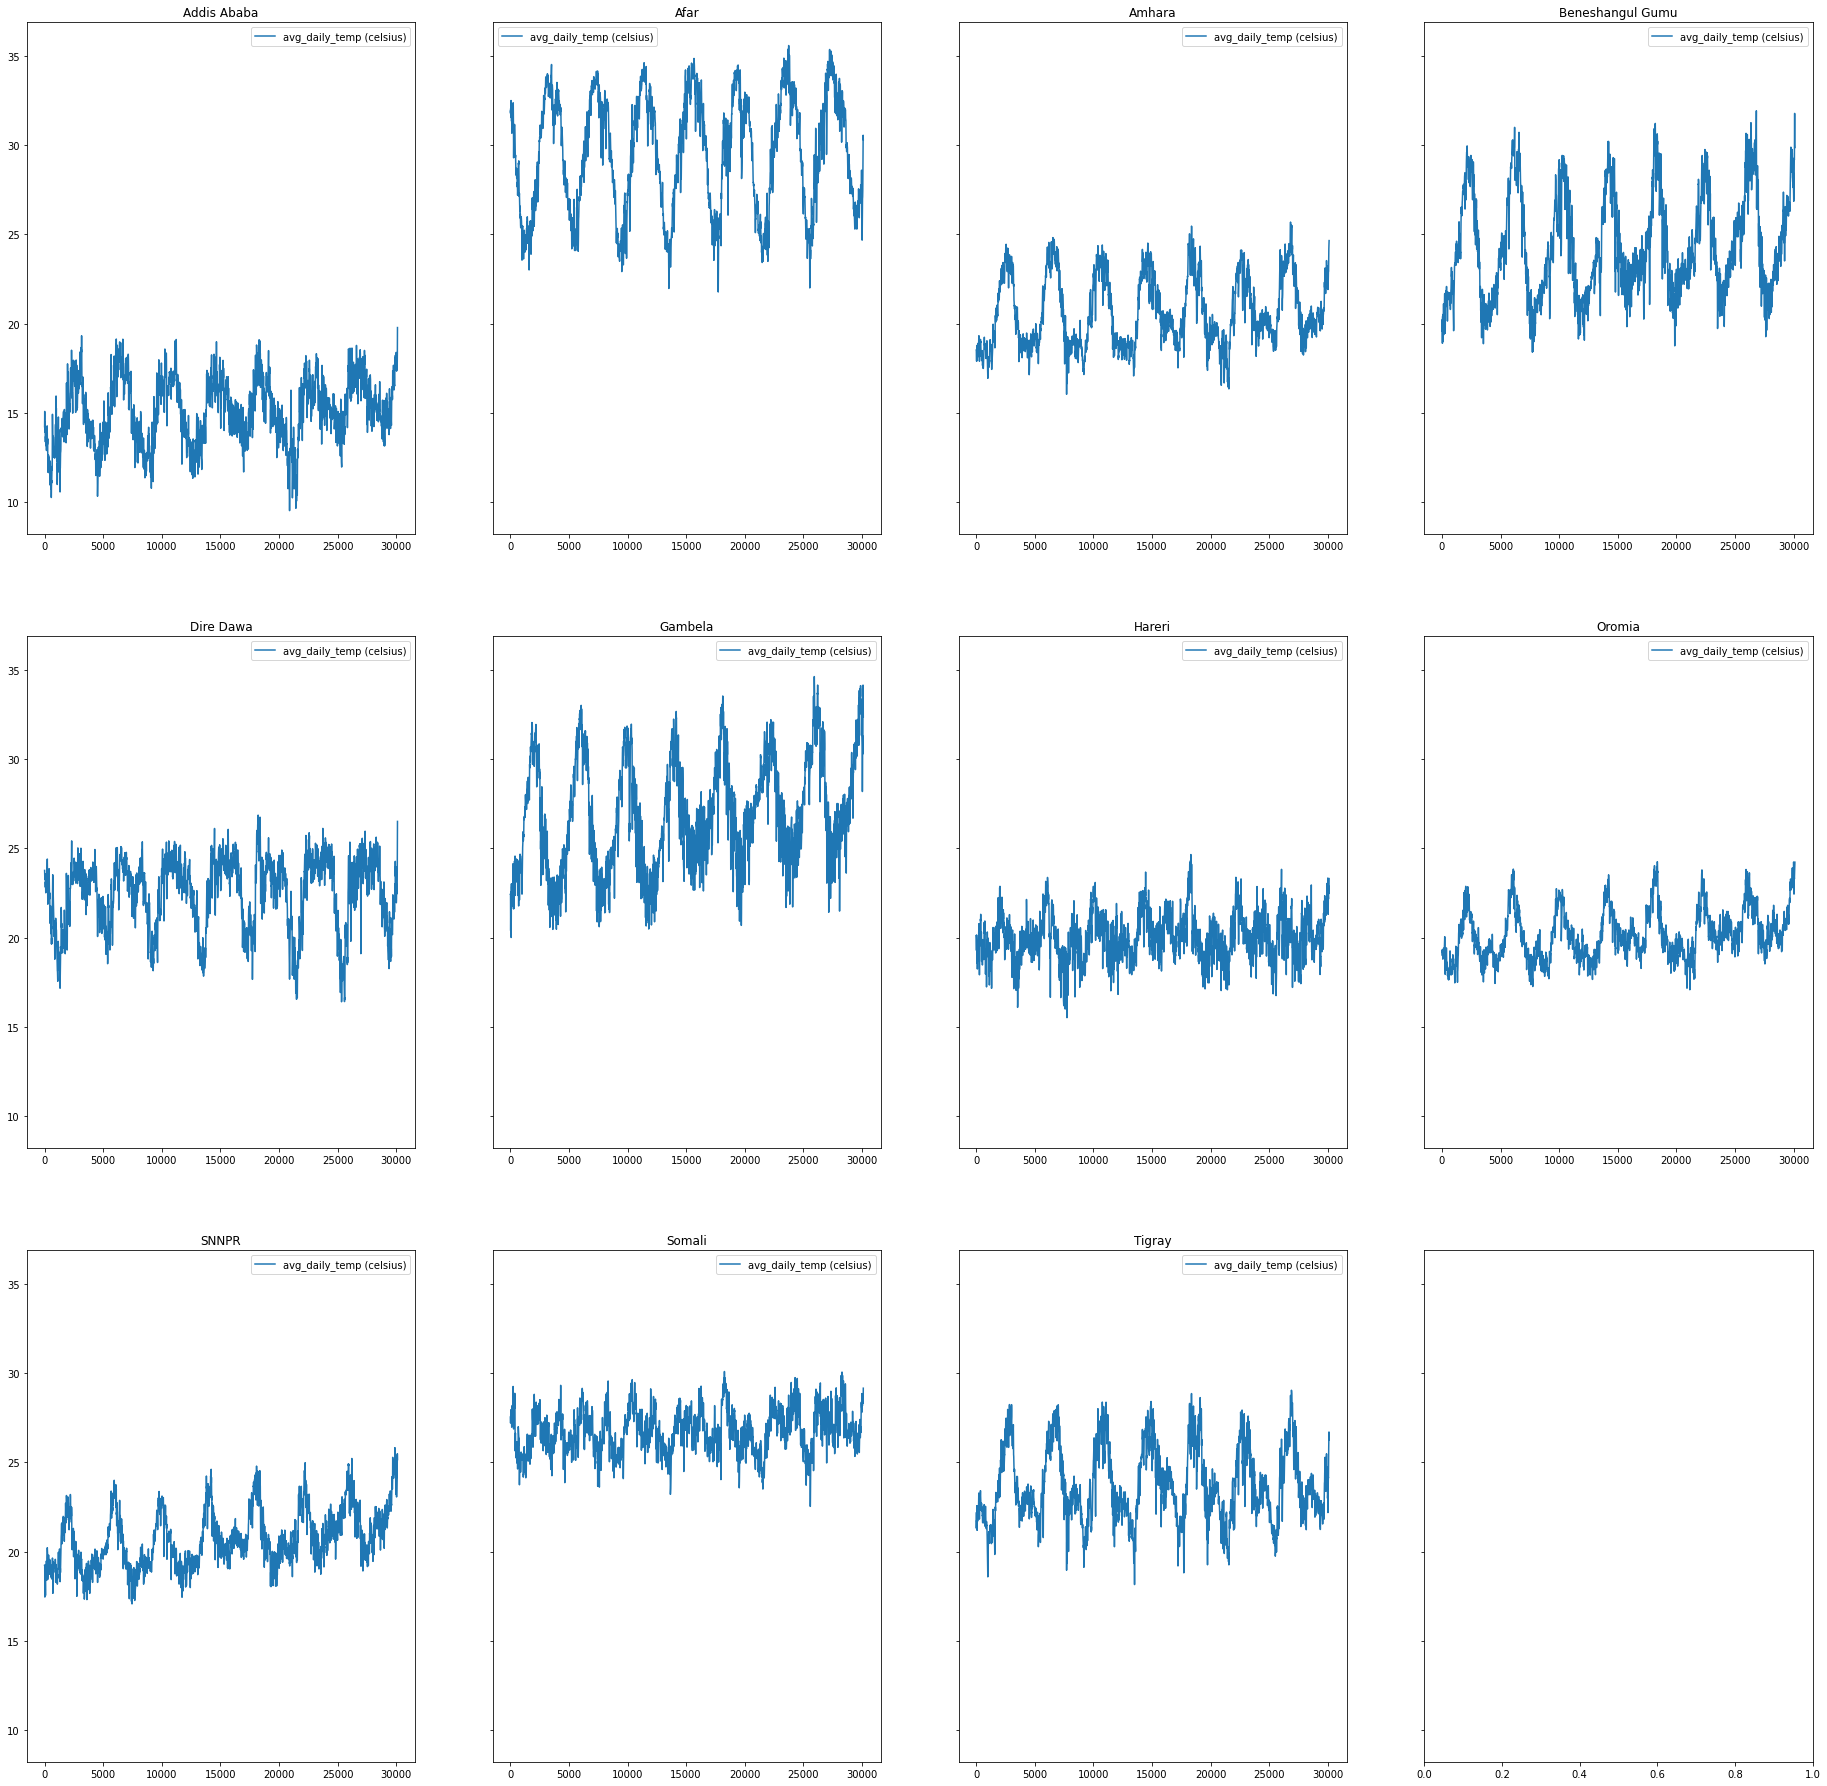

In [118]:
df = pd.DataFrame(rows)
grouped = df.groupby('region')
ncols = 4
nrows = int(np.ceil(grouped.ngroups/ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(32, 32), sharey=True)
for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
  grouped.get_group(key).plot(ax=ax, legend=True, title=key)
ax.legend()
plt.show()

In [119]:
df.to_csv(HOME_DIR + "/data/avg_daily_temp.csv")